# 2.Word2vector

Mètode per aprendre **associació de paraules** a través d'una xarxa neuronal (dues capes poc profundes; entrada, oculta, sortida).

*Method for learning ** word association ** through a neural network (two shallow layers; input, hidden, output).*

Utilitzat per detectar paraules com **sinònims** o per **suggerir paraules addicionals**.

*Used to detect words like ** synonyms ** or to ** suggest additional words **.*

**Sortida** a través conjunt de **vectors**. 
Les paraules són agrupades s'agruparan a prop en l'**espai** **vectorial**. 

*The **Output** through set of **vectors**.
The words that are grouped will be grouped together in the **space vector**. * 

Emprat per a **textos grans** (large datasets), i consta de més d'un algoritme.
*Used for **large datasets** and consists of more than one algorithm.*


# Codi implementacio word2vec


Llibreries utilitzades per el codi

 ***Libraries use for the code***

In [5]:

import re  # For preprocessing
import matplotlib
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


Llegim el dataset

**Read Dataset**

In [6]:

df = pd.read_csv('/content/simpsons_dataset.csv')
#df = pd.read_csv('/content/simpsons_script_lines.csv')
df.shape
df.head()
df.isnull().sum()

df = df.dropna().reset_index(drop=True)
df.isnull().sum()


raw_character_text    0
spoken_words          0
dtype: int64

Neteja utilitzant lemmatizing and removing the stopwords

**Clean dataset trough lemmatizing and removing the stopwords**


In [7]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Eliminar caracters no alfabetics

**Removes non-alphabetic characters:**


In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])


Accelerar el proces de neteja a traves de .pipe()

**Speed-up the cleaning process .pipe()**


In [9]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

Time to clean up everything: 1.34 mins


(85964, 1)

El paquet de Gensim, detecta automaticament frases comunes d'una llista interna.

**Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.**


In [10]:

from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=50, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]
word_freq = defaultdict(int)

for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
print(len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]


INFO - 11:18:11: 'pattern' package not found; tag filters are not available for English
INFO - 11:18:11: collecting all words and their counts
INFO - 11:18:11: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 11:18:11: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 11:18:11: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 11:18:11: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 11:18:12: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 11:18:12: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 11:18:12: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 11:18:12: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 11:18:12: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 11:18:12: collected 330804 word types f

30122


['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

Implementació del Word2Vec a traves llibreria gensim

**Gensim implementation of word2vec (CBOW)**


In [11]:

import multiprocessing
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
w2v_model = Word2Vec(min_count=10,window=2,size=300, sample=6e-5,alpha=0.03,min_alpha=0.0007, negative=20,workers=cores-1)
w2v_modelSG = Word2Vec(min_count=10,window=2,size=300, sample=6e-5,alpha=0.03,min_alpha=0.0007, negative=20,workers=cores-1, sg = 1)

Realitzacio del vocabulari

**Build the vocabulary table**

In [12]:
#%%  build the vocabulary table

t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_modelSG.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))


INFO - 11:18:18: collecting all words and their counts
INFO - 11:18:18: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:18:18: PROGRESS: at sentence #10000, processed 62120 words, keeping 9510 word types
INFO - 11:18:18: PROGRESS: at sentence #20000, processed 128130 words, keeping 14455 word types
INFO - 11:18:19: PROGRESS: at sentence #30000, processed 188948 words, keeping 17567 word types
INFO - 11:18:19: PROGRESS: at sentence #40000, processed 244707 words, keeping 20331 word types
INFO - 11:18:19: PROGRESS: at sentence #50000, processed 304872 words, keeping 22823 word types
INFO - 11:18:19: PROGRESS: at sentence #60000, processed 365976 words, keeping 25144 word types
INFO - 11:18:20: PROGRESS: at sentence #70000, processed 427741 words, keeping 27345 word types
INFO - 11:18:20: PROGRESS: at sentence #80000, processed 488108 words, keeping 29219 word types
INFO - 11:18:20: collected 30122 word types from a corpus of 526607 raw words and 85964 sentence

Time to build vocab: 0.11 mins


Train del model

**Model train**


In [13]:
#%% epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_modelSG.train(sentences, total_examples=w2v_modelSG.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.init_sims(replace=True)
w2v_modelSG.init_sims(replace=True)



INFO - 11:18:25: training model with 1 workers on 5393 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 11:18:26: EPOCH 1 - PROGRESS: at 27.30% examples, 62556 words/s, in_qsize 0, out_qsize 0
INFO - 11:18:27: EPOCH 1 - PROGRESS: at 53.41% examples, 59506 words/s, in_qsize 1, out_qsize 0
INFO - 11:18:28: EPOCH 1 - PROGRESS: at 81.81% examples, 61178 words/s, in_qsize 0, out_qsize 0
INFO - 11:18:28: worker thread finished; awaiting finish of 0 more threads
INFO - 11:18:28: EPOCH - 1 : training on 526607 raw words (232391 effective words) took 3.7s, 62481 effective words/s
INFO - 11:18:29: EPOCH 2 - PROGRESS: at 27.30% examples, 62839 words/s, in_qsize 0, out_qsize 0
INFO - 11:18:30: EPOCH 2 - PROGRESS: at 57.24% examples, 64014 words/s, in_qsize 0, out_qsize 0
INFO - 11:18:31: EPOCH 2 - PROGRESS: at 87.63% examples, 65629 words/s, in_qsize 0, out_qsize 0
INFO - 11:18:32: worker thread finished; awaiting finish of 0 more threads
INFO - 11:18:32: EPOCH

Time to train the model: 4.27 mins


Simulació del model

**Model simulation**

In [14]:
print(w2v_model.wv.most_similar(positive=["homer"]))
print(w2v_model.wv.most_similar(positive=["homer_simpson"]))
print(w2v_model.wv.similarity('maggie', 'baby'))
print(w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney']))
print(w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"]))
print(w2v_modelSG.wv.most_similar(positive=["homer"]))


[('cranky', 0.7869946956634521), ('midge', 0.7803788781166077), ('darle', 0.7773041129112244), ('uncomfortable', 0.7762109041213989), ('sec', 0.7682256698608398), ('alex', 0.7658209800720215), ('shush', 0.765267550945282), ('marge', 0.7648710608482361), ('temper', 0.7628090381622314), ('gee', 0.7588460445404053)]
[('presidential', 0.7566226720809937), ('recent', 0.7435868978500366), ('congratulation', 0.741347074508667), ('defendant', 0.7387981414794922), ('hotline', 0.7319936752319336), ('congratulate', 0.731313943862915), ('founder', 0.7292361259460449), ('behalf', 0.7247788906097412), ('resident', 0.7246007919311523), ('reign', 0.7240185737609863)]
0.75434494
milhouse
nelson
[('alex', 0.6783555746078491), ('meow', 0.6686080694198608), ('marge', 0.6572321653366089), ('midge', 0.6352239847183228), ('problemo', 0.62977135181427), ('uncomfortable', 0.6260114908218384), ('amnesia', 0.6242712736129761), ('cranky', 0.6237656474113464), ('darle', 0.6226682662963867), ('shush', 0.61982512474

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


Plot del model

**Plot of the model**

In [15]:


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    pca = PCA()
    tsne = TSNE(init=pca)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    pca = PCA(n_components=3)
    reduc =pca.fit_transform(arrays)
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],'y': [y for y in Y[:, 1]],'words': word_labels, 'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,x="x",y="y",fit_reg=False,marker="o",scatter_kws={'s': 40, 'facecolors': df['color'] })

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df['y'][line],
                '  ' + df["words"][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=df['color'][line],
                weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min() - 50, Y[:, 0].max() + 50)
    plt.ylim(Y[:, 1].min() - 50, Y[:, 1].max() + 50)

    plt.title('t-SNE visualization for {}'.format(word.title()))


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


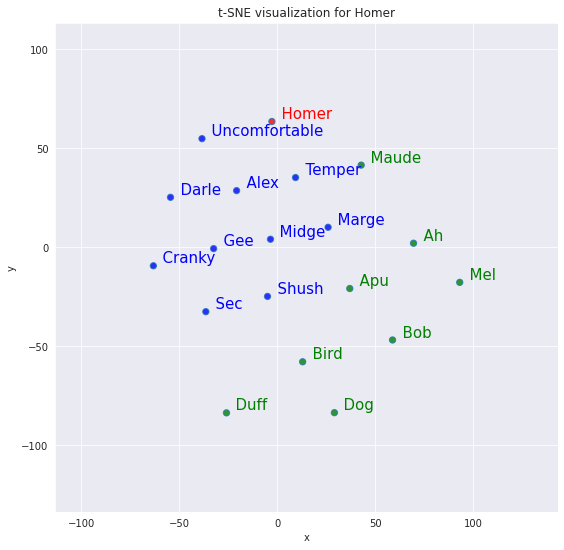

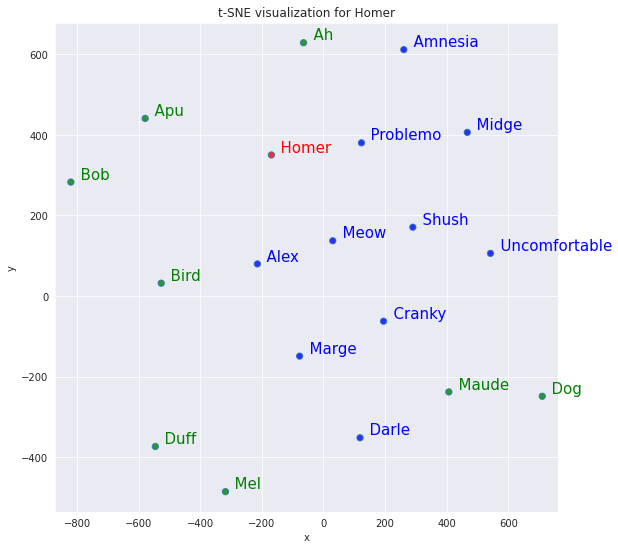

In [16]:

tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])
#tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

tsnescatterplot(w2v_modelSG, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])
